Get all needed libraries for EDA, Modeling, Hyperparameter tuning, and final calculations.

In [446]:
import time
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
#%matplotlib inline

# Mute the setting wtih a copy warnings
pd.options.mode.chained_assignment = None

#import plotly.express as px
import xgboost as xgb
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder, OneHotEncoder
from sklearn.preprocessing import MultiLabelBinarizer

from sklearn.naive_bayes import GaussianNB

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold, StratifiedKFold, cross_val_score

from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.pipeline import make_pipeline

from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import r2_score, plot_roc_curve, roc_auc_score, accuracy_score
from sklearn.metrics import classification_report, confusion_matrix

from sklearn.utils.validation import column_or_1d

import keras
import keras.utils
import tensorflow as tf
tf.config.run_functions_eagerly(True)
from keras import backend as K
from keras.models import Sequential
from keras.layers import Activation
from keras.layers.core import Dense
from keras.optimizers import adam_v2
from keras.callbacks import History
from keras.wrappers.scikit_learn import KerasClassifier
from keras.metrics import categorical_crossentropy

Read in the data, creating a Pandas DataFrame object.

In [307]:
file_df = pd.read_csv('/Users/soumyadeepray/Documents/Github/master-msis5223/Project/final_dataset.csv', sep=',')
file_df.head()

,Unnamed: 0,cat_number,rank,face,face-score,shirt,shirt-score,body,tier,tier-score,hats,hats-score,total
0,0,1,3474,sunglasses blue,3.2,winter red,38.9,blue cat skin,wild_1,1.9,hat black,61.4,105.4
1,2,3,9235,beard pirate,0.8,hoodie purple,6.4,blue cat skin,cool_2,5.0,mohawk purple,5.6,12.8
2,3,4,9413,unamused,2.0,buttondown tan,8.6,blue cat skin,cool_1,1.2,hat white,5.0,11.8
3,4,5,7088,sunglasses cool,10.0,shirt white,10.6,blue cat skin,cool_1,1.2,arrowhead,8.8,30.6
4,5,6,4700,sunglasses blue,3.2,work red,3.4,blue cat skin,cool_2,5.0,ninja red,74.0,80.5


In [308]:
file_df.shape

(8779, 13)

Exploratory Data Analysis

Look for duplicate entries, if we find any drop them and reset the index of our data frame

In [309]:
sum(file_df.duplicated())
file_df.columns

Index(['Unnamed: 0', 'cat_number', 'rank', 'face', 'face-score', 'shirt',
       'shirt-score', 'body', 'tier', 'tier-score', 'hats', 'hats-score',
       'total'],
      dtype='object')

Removing unnecessary index column

In [329]:
file_df = file_df.drop('Unnamed: 0', 1)
file_df = file_df.reset_index(drop=True)

/var/folders/jk/45pfmj415lb9l0__2lq4xmr40000gn/T/ipykernel_89322/1078296202.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  file_df = file_df.drop('Unnamed: 0', 1)


Looking for null values and outliers

In [6]:
file_df.isnull().sum()

cat_number     0
rank           0
face           0
face-score     0
shirt          0
shirt-score    0
body           0
tier           0
tier-score     0
hats           0
hats-score     0
total          0
dtype: int64

In [7]:
file_df.describe()

,cat_number,rank,face-score,shirt-score,tier-score,hats-score,total
count,8779.000000,8779.000000,8779.000000,8779.000000,8779.000000,8779.000000,8779.000000
mean,4827.984622,4961.916733,11.842567,43.018259,5.472901,46.951931,105.840369
std,2823.009065,2867.592038,110.854839,111.025395,7.849456,111.221122,324.952094
min,1.000000,1.000000,0.000000,0.000000,1.200000,3.000000,0.200000
25%,2376.500000,2473.500000,3.200000,4.400000,1.900000,5.600000,22.300000
50%,4843.000000,4972.000000,4.800000,34.900000,5.000000,44.500000,70.200000
75%,7202.500000,7437.500000,7.300000,68.400000,5.000000,71.500000,139.700000
max,9932.000000,9933.000000,3275.300000,3267.800000,62.400000,3273.400000,9878.800000


We see that the variation of scores for the characteristics (face, shirt, tier, hats) is large. The top ranked cool cats have the largest scores. 

In [ ]:
file_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8779 entries, 0 to 8778
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   cat_number   8779 non-null   int64  
 1   rank         8779 non-null   int64  
 2   face         8779 non-null   object 
 3   face-score   8779 non-null   float64
 4   shirt        8779 non-null   object 
 5   shirt-score  8779 non-null   float64
 6   body         8779 non-null   object 
 7   tier         8779 non-null   object 
 8   tier-score   8779 non-null   float64
 9   hats         8779 non-null   object 
 10  hats-score   8779 non-null   float64
 11  total        8779 non-null   float64
dtypes: float64(5), int64(2), object(5)
memory usage: 823.2+ KB


Data Visualization

We'll have a look at the distribution of the overall score here.

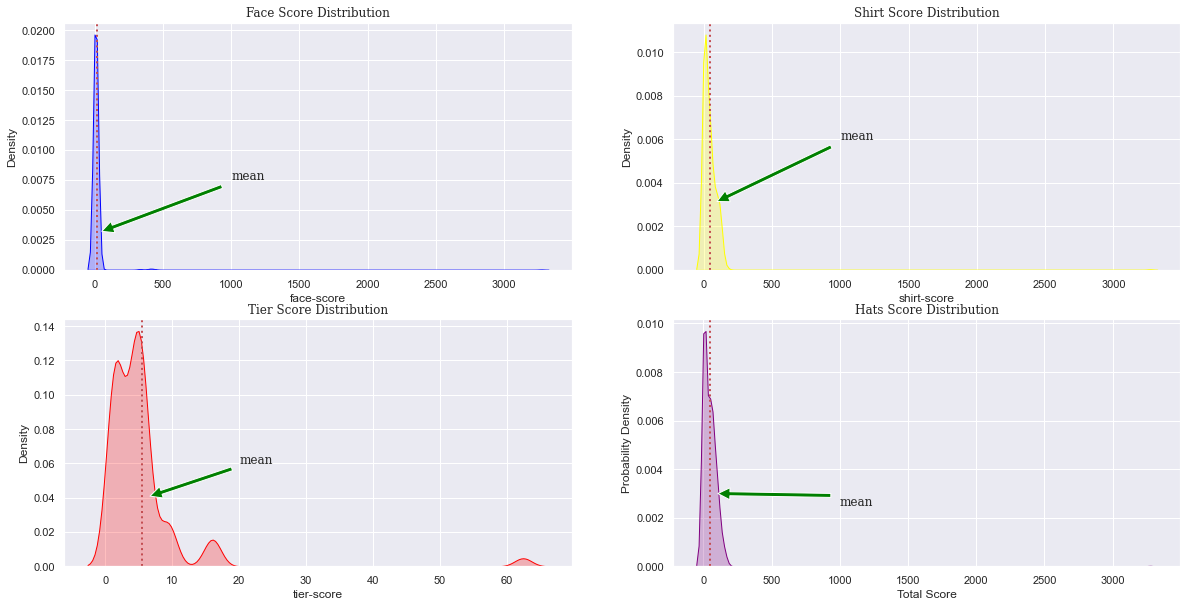

In [310]:
# Plotting the KDE Plot
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2,figsize=(20,10))
sns.kdeplot(file_df['face-score'], color='blue', shade=True, ax =ax1)
ax1.set_title("Face Score Distribution",font="Serif")
ax1.axvline(file_df['face-score'].mean(), color='r',linestyle=':', linewidth=2)
ax1.annotate('mean', xy=(0,0.003), xytext=(1000, 0.0075), font='Serif',
            arrowprops = dict(facecolor ='green',
                               shrink = 0.05));                               

sns.kdeplot(file_df['shirt-score'], color='yellow', shade=True, ax =ax2)
ax2.set_title("Shirt Score Distribution",font="Serif")
ax2.axvline(file_df['shirt-score'].mean(), color='r',linestyle=':', linewidth=2)
ax2.annotate('mean', xy=(50,0.003), xytext=(1000, 0.006), font='Serif',
            arrowprops = dict(facecolor ='green',
                               shrink = 0.05));

sns.kdeplot(file_df['tier-score'], color='red', shade=True, ax =ax3)
ax3.set_title("Tier Score Distribution",font="Serif")
ax3.axvline(file_df['tier-score'].mean(), color='r',linestyle=':', linewidth=2)
ax3.annotate('mean', xy=(6,0.04), xytext=(20, 0.06), font='Serif',
            arrowprops = dict(facecolor ='green',
                               shrink = 0.05));

sns.kdeplot(file_df['hats-score'], color='purple', shade=True, ax =ax4)
ax4.set_title("Hats Score Distribution",font="Serif")
ax4.axvline(file_df['hats-score'].mean(), color='r',linestyle=':', linewidth=2)
ax4.annotate('mean', xy=(60,0.003), xytext=(1000, 0.0025), font='Serif',
            arrowprops = dict(facecolor ='green',
                               shrink = 0.05));
# Setting the X and Y Label
plt.xlabel('Total Score')
plt.ylabel('Probability Density')
plt.show()

In [311]:
def get_top_n_categories(column, n):
    score_dict ={}
    score_column = column + '-score'
    properties = pd.Series(file_df[column]).unique()
    for property in properties:
        score = file_df.loc[file_df[column]==property, score_column].unique()
        score_dict[property] = score[0]
    score_dict =sorted(score_dict.items(), key = lambda x: x[1], reverse=True)
    return score_dict[:n]

In [312]:
get_top_n_categories('tier',20)

[('exotic_2', 62.4),
 ('exotic_1', 16.0),
 ('classy_2', 9.4),
 ('classy_1', 6.2),
 ('cool_2', 5.0),
 ('wild_2', 4.2),
 ('wild_1', 1.9),
 ('cool_1', 1.2)]

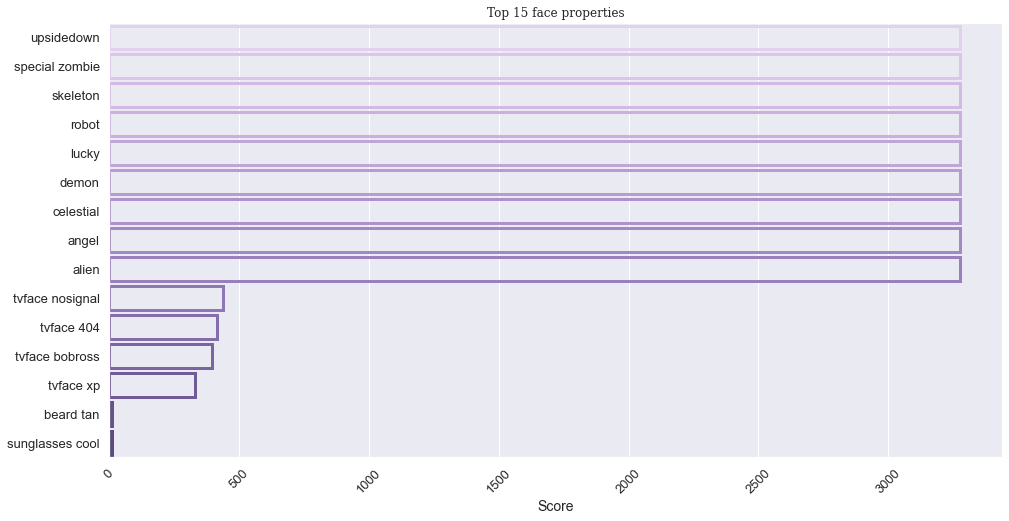

In [313]:
top_face_properties =  get_top_n_categories('face',15)
top_face_properties_df = pd.DataFrame(top_face_properties,columns=['property','score'])
plt.figure(figsize=(16, 8))
ax = sns.barplot(x='score', y='property', data=top_face_properties_df,facecolor=(0, 0, 0, 0),linewidth=3,edgecolor=sns.color_palette("ch:start=3, rot=.1",20))
plt.title("Top 15 face properties",font='Serif')
plt.xlabel("Score", fontsize=14)
plt.yticks(fontsize=13)
plt.xticks(rotation=45, fontsize=13)
plt.ylabel("");
plt.show()

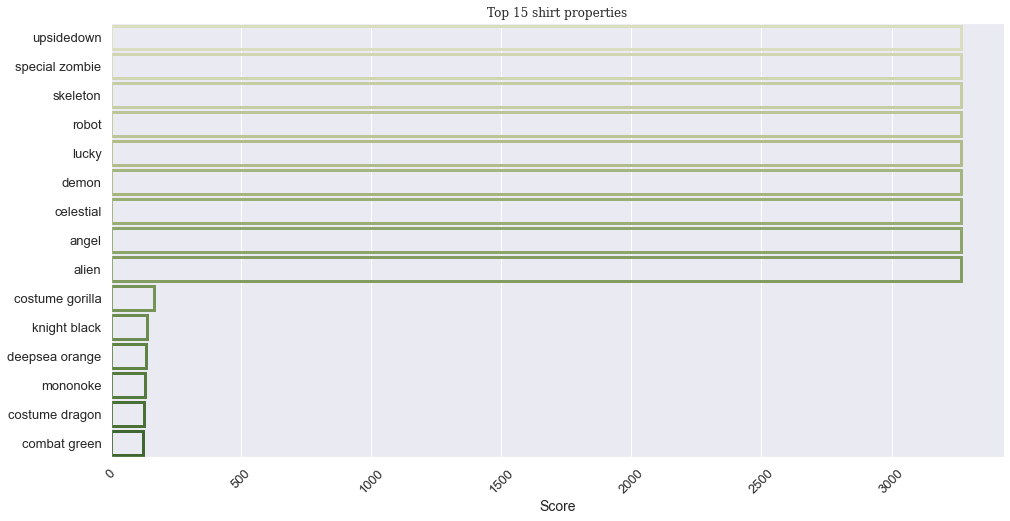

In [196]:
top_shirt_properties =  get_top_n_categories('shirt',15)
top_shirt_properties_df = pd.DataFrame(top_shirt_properties,columns=['property','score'])
plt.figure(figsize=(16, 8))
ax = sns.barplot(x='score', y='property', data=top_shirt_properties_df,facecolor=(0, 0, 0, 0),linewidth=3,edgecolor=sns.color_palette("ch:start=2, rot=-.2",20))
plt.title("Top 15 shirt properties",font='Serif')
plt.xlabel("Score", fontsize=14)
plt.yticks(fontsize=13)
plt.xticks(rotation=45, fontsize=13)
plt.ylabel("");
plt.show()

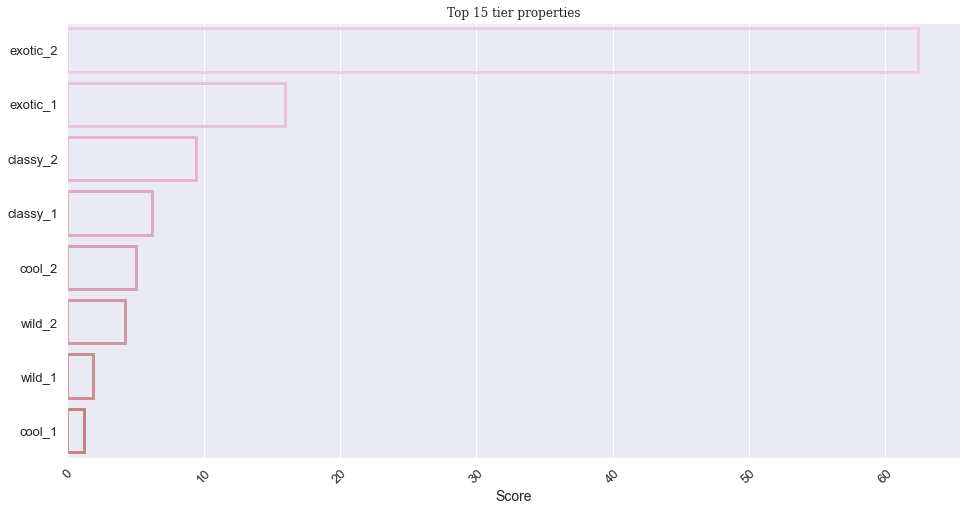

In [207]:
top_tier_properties =  get_top_n_categories('tier',15)
top_tier_properties_df = pd.DataFrame(top_tier_properties,columns=['property','score'])
plt.figure(figsize=(16, 8))
ax = sns.barplot(x='score', y='property', data=top_tier_properties_df,facecolor=(0, 0, 0, 0),linewidth=3,edgecolor=sns.color_palette("ch:start=-1, rot=-.6",20))
plt.title("Top 15 tier properties",font='Serif')
plt.xlabel("Score", fontsize=14)
plt.yticks(fontsize=13)
plt.xticks(rotation=45, fontsize=13)
plt.ylabel("");
plt.show()

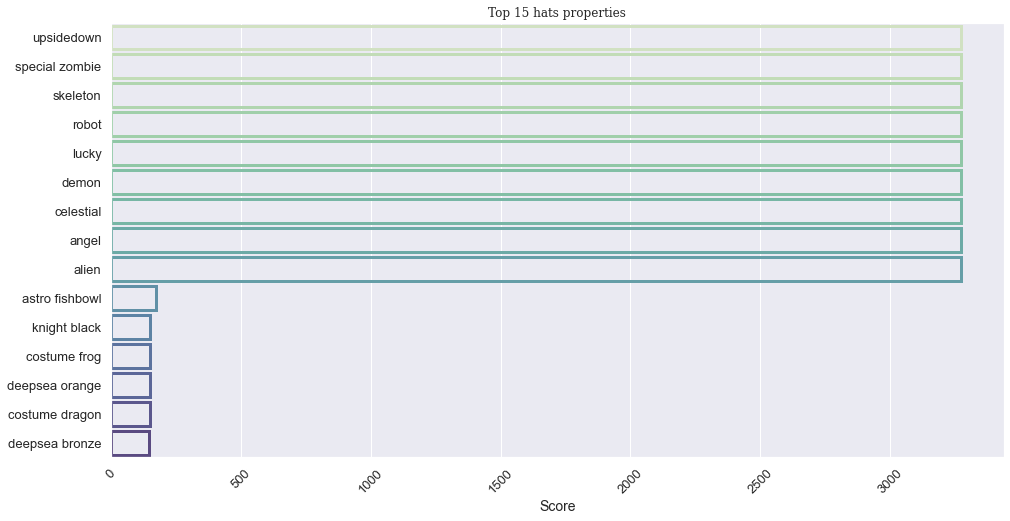

In [208]:
top_hats_properties =  get_top_n_categories('hats',15)
top_hats_properties_df = pd.DataFrame(top_hats_properties,columns=['property','score'])
plt.figure(figsize=(16, 8))
ax = sns.barplot(x='score', y='property', data=top_hats_properties_df,facecolor=(0, 0, 0, 0),linewidth=3,edgecolor=sns.color_palette("ch:start=-8, rot=-.9",20))
plt.title("Top 15 hats properties",font='Serif')
plt.xlabel("Score", fontsize=14)
plt.yticks(fontsize=13)
plt.xticks(rotation=45, fontsize=13)
plt.ylabel("");
plt.show()

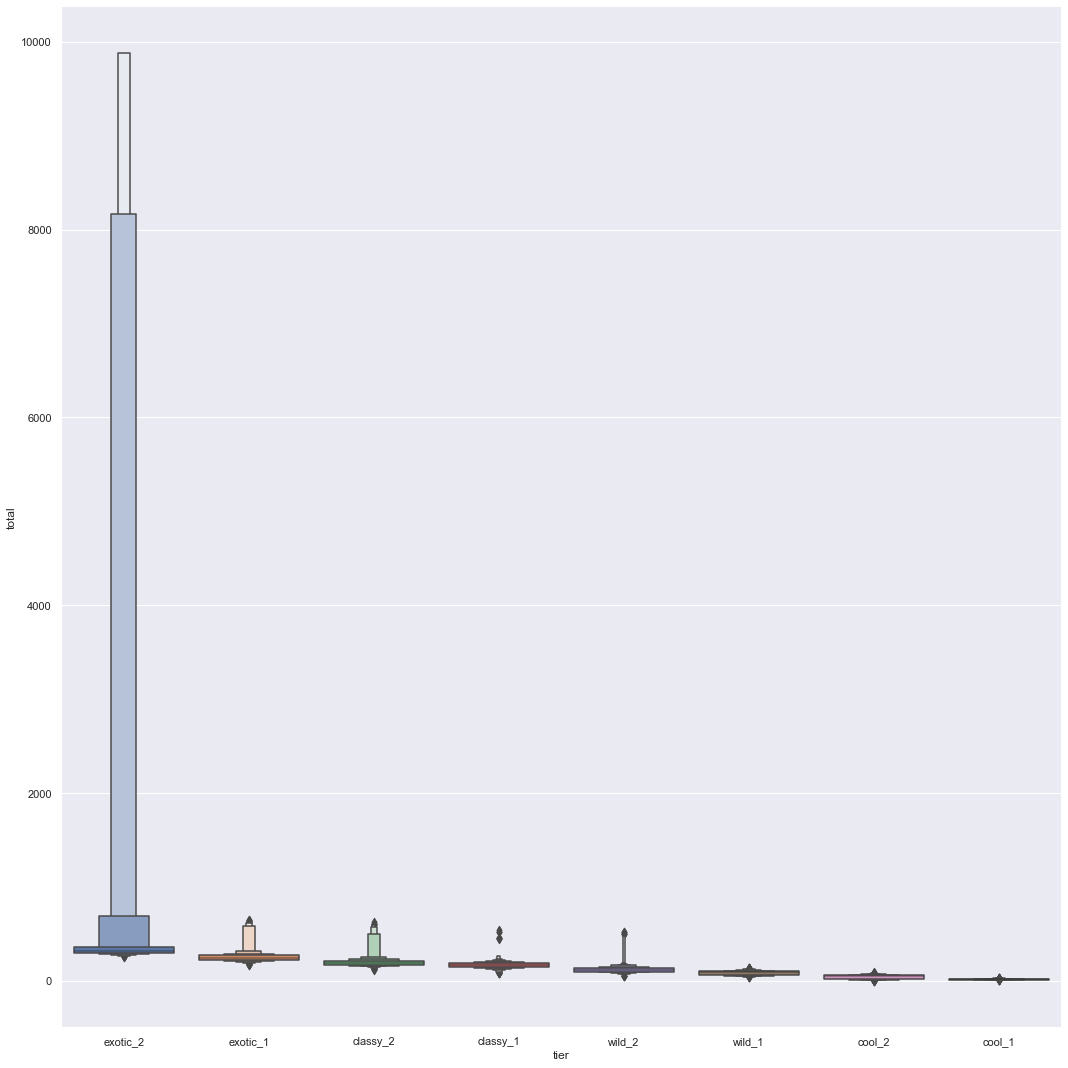

In [314]:
sns.catplot(y = "total", x = "tier", data = file_df.sort_values("total", ascending = False), kind="boxen", height = 15, aspect = 1)
plt.show()

In [315]:
file_df.corr()

,Unnamed: 0,cat_number,rank,face-score,shirt-score,tier-score,hats-score,total
Unnamed: 0,1.000000,1.000000,0.000969,0.005541,0.000057,0.007517,-0.003524,0.000896
cat_number,1.000000,1.000000,0.000969,0.005541,0.000058,0.007517,-0.003524,0.000896
rank,0.000969,0.000969,1.000000,-0.107185,-0.338908,-0.460743,-0.351481,-0.286949
face-score,0.005541,0.005541,-0.107185,1.000000,0.888773,0.290245,0.889661,0.956586
shirt-score,0.000057,0.000058,-0.338908,0.888773,1.000000,0.392478,0.918997,0.969897
tier-score,0.007517,0.007517,-0.460743,0.290245,0.392478,1.000000,0.384382,0.389217
hats-score,-0.003524,-0.003524,-0.351481,0.889661,0.918997,0.384382,1.000000,0.970088
total,0.000896,0.000896,-0.286949,0.956586,0.969897,0.389217,0.970088,1.000000


<AxesSubplot:>

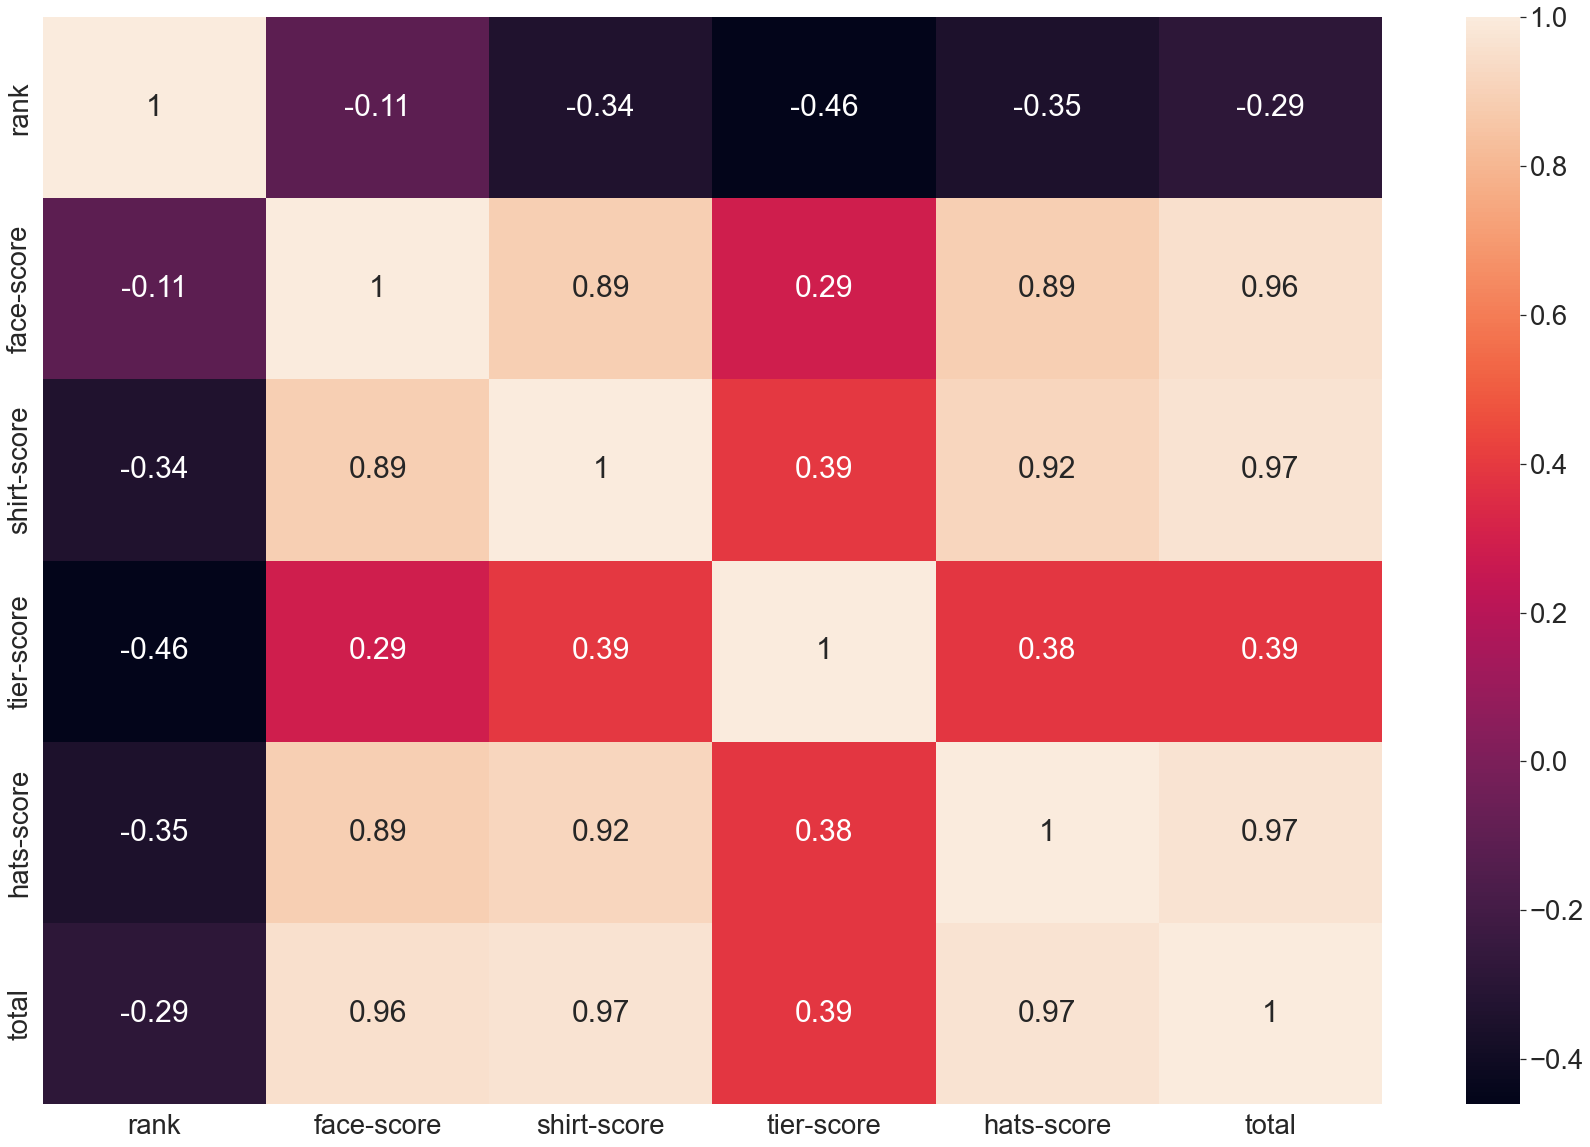

In [316]:
sns.set(font_scale=2.5)
plt.figure(figsize=(30,20))
sns.heatmap(file_df[['rank', 'face-score','shirt-score','tier-score','hats-score', 'total']].corr(), annot=True)


Outlier Removal

To remove outliers, we use the Inter Quartile Range (IQR) rule. Instead of 25% quartiles, we'll use a smaller rejection area (keeping from 0.01 - 99.99 percentile. Thats because the above the kde plots didn't seem to show too many score points that can be considered outliers.

Checking the outliers at 25%, 50%, 75%, 90%, 95%, 99% and 99.6%

In [317]:
numeric = file_df[['face-score','shirt-score', 'tier-score','hats-score','total']]
numeric.describe(percentiles=[.25,.5,.75,.90,.95,.98,.99,.996])

,face-score,shirt-score,tier-score,hats-score,total
count,8779.000000,8779.000000,8779.000000,8779.000000,8779.000000
mean,11.842567,43.018259,5.472901,46.951931,105.840369
std,110.854839,111.025395,7.849456,111.221122,324.952094
min,0.000000,0.000000,1.200000,3.000000,0.200000
25%,3.200000,4.400000,1.900000,5.600000,22.300000
50%,4.800000,34.900000,5.000000,44.500000,70.200000
75%,7.300000,68.400000,5.000000,71.500000,139.700000
90%,9.100000,110.700000,9.400000,107.200000,202.400000
95%,10.000000,118.300000,16.000000,118.800000,242.130000
98%,10.200000,129.800000,16.000000,148.500000,299.744000


Capping the outliers for total score

/opt/homebrew/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='total'>

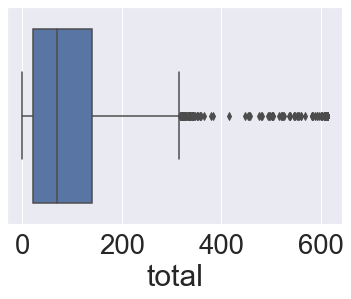

In [318]:
q = file_df['total'].quantile(0.996)
file_df['total'][file_df['total']>=q] = q
sns.boxplot(file_df['total'])

Capping the outliers for face-score

/opt/homebrew/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='face-score'>

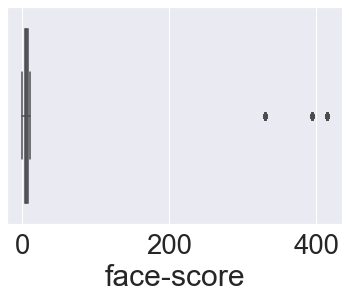

In [320]:
q = file_df['face-score'].quantile(0.996)
file_df['face-score'][file_df['face-score']>=q] = q
sns.boxplot(file_df['face-score'])

Caping the outliers for shirt-score

/opt/homebrew/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='shirt-score'>

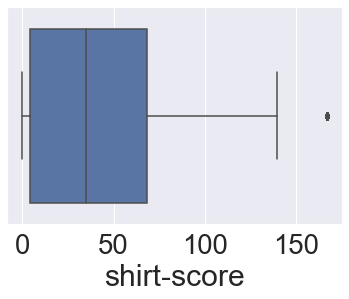

In [321]:
q = file_df['shirt-score'].quantile(0.996)
file_df['shirt-score'][file_df['shirt-score']>=q] = q
sns.boxplot(file_df['shirt-score'])

Caping the outliers for hats-score

/opt/homebrew/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='hats-score'>

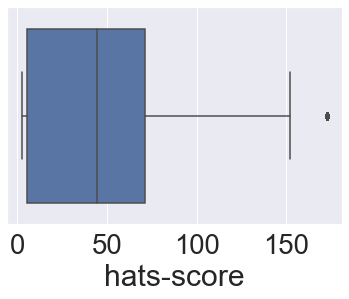

In [323]:
q = file_df['hats-score'].quantile(0.996)
file_df['hats-score'][file_df['hats-score']>=q] = q
sns.boxplot(file_df['hats-score'])

In [324]:
file_df.describe()

,Unnamed: 0,cat_number,rank,face-score,shirt-score,tier-score,hats-score,total
count,8779.000000,8779.000000,8779.000000,8779.000000,8779.000000,8779.000000,8779.000000,8779.000000
mean,4827.082811,4827.984622,4961.916733,8.870669,39.839298,5.472901,43.772970,96.168131
std,2823.174424,2823.009065,2867.592038,38.657032,40.866216,7.849456,41.266833,87.460018
min,0.000000,1.000000,1.000000,0.000000,0.000000,1.200000,3.000000,0.200000
25%,2375.500000,2376.500000,2473.500000,3.200000,4.400000,1.900000,5.600000,22.300000
50%,4842.000000,4843.000000,4972.000000,4.800000,34.900000,5.000000,44.500000,70.200000
75%,7201.500000,7202.500000,7437.500000,7.300000,68.400000,5.000000,71.500000,139.700000
max,9933.000000,9932.000000,9933.000000,414.600000,166.900000,62.400000,172.500000,611.431200


Creating a Baseline Model using Ridge and Linear Regression

Splitting the data into parts.

First part has all the numerical features and the second part will have the traget variable.

In [114]:
X = file_df[['rank','face-score','shirt-score','total','hats-score']] #.drop('total', axis = 1)
y = file_df['tier-score']

In [325]:
def training(model, X_train, y_train, X_test, y_test, model_name):
    
    model = make_pipeline(StandardScaler(with_mean=False),model,)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    MSE = mse(y_test, y_pred)
    R2_Score = r2_score(y_test, y_pred)
    
    print("--- Model:", model_name,"---")
    print("MSE: ",MSE)
    print("R2 Score", R2_Score)
    
ridge = Ridge(fit_intercept = True)
lr = LinearRegression()
m = [ridge,lr]
mn = ["Ridge Regression","Linear Regression"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

for i in range(0,len(m)):
    training(model=m[i], X_train=X_train, y_train=y_train, X_test=X_test,y_test=y_test, model_name=mn[i])

--- Model: Ridge Regression ---
MSE:  19.824752345233275
R2 Score 0.6605432179583355
--- Model: Linear Regression ---
MSE:  19.67276943176207
R2 Score 0.6631456025850799


Using Label Encoding on the target variable (tier) so that we can assign a number to each of the rarity feature.

In [330]:
le = LabelEncoder()
file_df['tier_encoded'] = le.fit_transform(file_df['tier'])
file_df

,cat_number,rank,face,face-score,shirt,shirt-score,body,tier,tier-score,hats,hats-score,total,tier_encoded
0,1,3474,sunglasses blue,3.2,winter red,38.9,blue cat skin,wild_1,1.9,hat black,61.4,105.4,6
1,3,9235,beard pirate,0.8,hoodie purple,6.4,blue cat skin,cool_2,5.0,mohawk purple,5.6,12.8,3
2,4,9413,unamused,2.0,buttondown tan,8.6,blue cat skin,cool_1,1.2,hat white,5.0,11.8,2
3,5,7088,sunglasses cool,10.0,shirt white,10.6,blue cat skin,cool_1,1.2,arrowhead,8.8,30.6,2
4,6,4700,sunglasses blue,3.2,work red,3.4,blue cat skin,cool_2,5.0,ninja red,74.0,80.5,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8774,9927,9530,sunglasses heart,3.0,sweater orange,8.0,blue cat skin,cool_2,5.0,hat white,5.0,11.0,3
8775,9928,3342,face face,9.1,tanktop sailor red,39.7,blue cat skin,wild_1,1.9,afro black,57.5,108.2,6
8776,9929,3455,sunglasses squad,9.1,tanktop sailor black,42.6,blue cat skin,wild_2,4.2,pirate red,49.8,105.7,7
8777,9931,4652,zombie,1.1,shirt yellow,4.4,blue cat skin,wild_1,1.9,wreath flowers,75.2,82.6,6


In [348]:
le.classes_

array(['classy_1', 'classy_2', 'cool_1', 'cool_2', 'exotic_1', 'exotic_2',
       'wild_1', 'wild_2'], dtype=object)

Knowing the labels of the tier classes

In [353]:
le_name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print(le_name_mapping)

{'classy_1': 0,
 'classy_2': 1,
 'cool_1': 2,
 'cool_2': 3,
 'exotic_1': 4,
 'exotic_2': 5,
 'wild_1': 6,
 'wild_2': 7}

In [356]:
target_names = list(le_name_mapping.keys())
target_names

['classy_1',
 'classy_2',
 'cool_1',
 'cool_2',
 'exotic_1',
 'exotic_2',
 'wild_1',
 'wild_2']

In [345]:
file_df['tier'].value_counts(normalize = True)

cool_2      0.260508
cool_1      0.198656
wild_1      0.174963
wild_2      0.123704
classy_1    0.100809
classy_2    0.076432
exotic_1    0.049892
exotic_2    0.015036
Name: tier, dtype: float64

In [69]:
print('Exotic_2 consists of', round(file_df['tier'].value_counts()[7]/len(file_df) * 100,2), '% of the dataset')
print('Cool_2 consists of', round(file_df['tier'].value_counts()[0]/len(file_df) * 100,2), '% of the dataset')

Exotic_2 consists of 1.5 % of the dataset
Cool_2 consists of 26.05 % of the dataset


Stratified KFold

The stratified k fold cross-validation is an extension of the cross-validation technique used for classification problems. It maintains the same class ratio throughout the K folds as the ratio in the original dataset.

Here we find that the various categories of tier has uneven distribution. So we will use the stratified k fold cross-validation technique so that the class ratio is preserved through the K folds.

In [104]:
fold_no = 1
y_skf = file_df['tier_encoded']
skf = StratifiedKFold(n_splits=5, random_state=None, shuffle=False)
for train_index, test_index in skf.split(X, y_skf):
    print("Train:", train_index, "Test:", test_index)
    original_Xtrain, original_Xtest = X.iloc[train_index], X.iloc[test_index]
    original_ytrain, original_ytest = y_skf.iloc[train_index], y_skf.iloc[test_index]
    fold_no += 1


Train: [1580 1581 1589 ... 8776 8777 8778] Test: [   0    1    2 ... 2011 2029 2112]
Train: [   0    1    2 ... 8776 8777 8778] Test: [1580 1581 1589 ... 3642 3645 3807]
Train: [   0    1    2 ... 8776 8777 8778] Test: [3275 3276 3285 ... 5365 5368 5494]
Train: [   0    1    2 ... 8776 8777 8778] Test: [5135 5140 5142 ... 7234 7254 7269]
Train: [   0    1    2 ... 7234 7254 7269] Test: [6908 6956 6968 ... 8776 8777 8778]


Turn each of the data splits into arrays

In [105]:
original_Xtrain = original_Xtrain.values
original_Xtest = original_Xtest.values
original_ytrain = original_ytrain.values
original_ytest = original_ytest.values

Now we see if both the train and test label distribution are similarly distributed by compating the ratios

In [106]:
train_unique_label, train_counts_label = np.unique(original_ytrain, return_counts=True)
test_unique_label, test_counts_label = np.unique(original_ytest, return_counts=True)
print("train_counts_label %s" % train_counts_label)
print("test_counts_label %s" % test_counts_label)
print('\nLabel Distributions: \n')
print(train_counts_label/ len(original_ytrain))
print(test_counts_label/ len(original_ytest))

train_counts_label [ 708  537 1395 1830  350  106 1229  869]
test_counts_label [177 134 349 457  88  26 307 217]

Label Distributions: 

[0.10079727 0.07645216 0.19860478 0.26053531 0.04982916 0.01509112
 0.17497153 0.12371868]
[0.1008547  0.07635328 0.1988604  0.26039886 0.05014245 0.01481481
 0.17492877 0.12364672]


Using Naive Bayes classifier as a model for Stratified KFold. 
It is termed as ‘Naive’ because it assumes independence between every pair of features in the data.

Build a custom function to pass our data splits to for training and testing.

In [145]:
gnb = GaussianNB()
dct = DecisionTreeClassifier()
rt = RandomForestClassifier()

In [163]:
def train_model(train, test, fold_no):
    X_features = ['face-score','shirt-score','total','hats-score']
    y_target_var = ['tier_encoded']
    y_target_var = column_or_1d(y_target_var, warn = True)
    X_train = train[X_features]
    y_train = train[y_target_var]
    X_test = test[X_features]
    y_test = test[y_target_var]
    gnb.fit(X_train,y_train)
    dct.fit(X_train,y_train)
    rt.fit(X_train,y_train)
    predictions_gnb = gnb.predict(X_test)
    predictions_dct = dct.predict(X_test)
    predictions_rt = rt.predict(X_test)
    print('Fold',str(fold_no),'Accuracy:',accuracy_score(y_test,predictions_gnb), accuracy_score(y_test,predictions_dct), accuracy_score(y_test,predictions_rt))

In [164]:
fold_no = 1
for train_index, test_index in skf.split(file_df, y_skf):
    train = file_df.loc[train_index,:]
    test = file_df.loc[test_index,:]
    print('-'*50)
    #print(test)
    train_model(train,test,fold_no)
    fold_no += 1

--------------------------------------------------


/opt/homebrew/lib/python3.9/site-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/var/folders/jk/45pfmj415lb9l0__2lq4xmr40000gn/T/ipykernel_89322/2914992542.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rt.fit(X_train,y_train)


Fold 1 Accuracy: 0.6110478359908884 0.8337129840546698 0.8621867881548975
--------------------------------------------------


/opt/homebrew/lib/python3.9/site-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/var/folders/jk/45pfmj415lb9l0__2lq4xmr40000gn/T/ipykernel_89322/2914992542.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rt.fit(X_train,y_train)


Fold 2 Accuracy: 0.5876993166287016 0.8354214123006833 0.8559225512528473
--------------------------------------------------


/opt/homebrew/lib/python3.9/site-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/var/folders/jk/45pfmj415lb9l0__2lq4xmr40000gn/T/ipykernel_89322/2914992542.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rt.fit(X_train,y_train)


Fold 3 Accuracy: 0.6070615034168565 0.8388382687927107 0.8599088838268792
--------------------------------------------------


/opt/homebrew/lib/python3.9/site-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/var/folders/jk/45pfmj415lb9l0__2lq4xmr40000gn/T/ipykernel_89322/2914992542.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rt.fit(X_train,y_train)


Fold 4 Accuracy: 0.6167425968109339 0.8337129840546698 0.8559225512528473
--------------------------------------------------


/opt/homebrew/lib/python3.9/site-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/var/folders/jk/45pfmj415lb9l0__2lq4xmr40000gn/T/ipykernel_89322/2914992542.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rt.fit(X_train,y_train)


Fold 5 Accuracy: 0.6005698005698006 0.81994301994302 0.8467236467236468


`Hyperparameter Tuning`

Using `GridSearchCV` to find the best parameters

GridSearchCV for Naive Bayes Algorithm

In [167]:
param_grid_nb = {
    'var_smoothing': np.logspace(0,-9, num=100)
}

`var_smoothing` is a stability calculation to widen (or smooth) the curve and therefore account for more samples that are further away from the distribution mean. In this case, np.logspace returns numbers spaced evenly on a log scale, starts from 0, ends at -9, and generates 100 samples.

Parameters-
1. estimator is the machine learning model of interest
2. param_grid is a dictionary with parameter names (string) as keys and lists of parameter settings to try as values
3. cv is the cross validation generator 
4. verbose is the verbosity: the higher, the more messages

In [178]:
gs_NB = GridSearchCV(estimator=gnb, param_grid=param_grid_nb, cv=10,verbose=1,scoring='accuracy')
gs_NB.fit(original_Xtrain, original_ytrain)
print('Single best score achieved across all params: \n', gs_NB.best_score_)
print('Dictionary of parameters (min_samples_split) used to generate that score \n', gs_NB.best_params_)
print('Best Estimator: \n', gs_NB.best_estimator_)


Fitting 10 folds for each of 100 candidates, totalling 1000 fits
Single best score achieved across all params: 
 0.6187379687379687
Dictionary of parameters (min_samples_split) used to generate that score 
 {'var_smoothing': 4.328761281083062e-05}
Best Estimator: 
 GaussianNB(var_smoothing=4.328761281083062e-05)


Using the best parameters obtained from GridSearchCV to trtain the Naive Bayes model.

In [180]:
gnb_1 = GaussianNB(var_smoothing = 4.328761281083062e-05)
gnb_1.fit(original_Xtrain, original_ytrain)

GaussianNB(var_smoothing=4.328761281083062e-05)

Predictions and Accuracy score of the new Naive Bayes model

In [184]:
predictions_gnb_1 = gnb_1.predict(original_Xtest)
print("Accuracy for GaussianNB on CV data: ",accuracy_score(original_ytest,predictions_gnb_1))

Accuracy for Random Forest on CV data:  0.5920227920227921


In [357]:
print(classification_report(original_ytest,predictions_gnb_1, target_names=target_names))

              precision    recall  f1-score   support

    classy_1       0.46      0.73      0.56       177
    classy_2       0.43      0.07      0.12       134
      cool_1       0.67      1.00      0.80       349
      cool_2       0.72      0.48      0.57       457
    exotic_1       0.62      0.72      0.66        88
    exotic_2       0.38      0.46      0.41        26
      wild_1       0.53      0.62      0.57       307
      wild_2       0.50      0.32      0.39       217

    accuracy                           0.59      1755
   macro avg       0.54      0.55      0.51      1755
weighted avg       0.59      0.59      0.56      1755



Using GridSearchCV on the Naive Bayes has not effectively increased the performance of the model. 

GridSearchCV for Decision Tree Classifier

In [226]:
sample_split_range = list(range(2, 50))
#param_grid = dict(min_samples_split=sample_split_range)
#params = {'max_leaf_nodes': list(range(2, 100)), 'min_samples_split': [2, 3, 4]}
param_grid = {'min_samples_split': sample_split_range,
              #'max_features': ['auto', 'sqrt', 'log2'],
              'ccp_alpha': [0.0, 0.1, .01, .001],
              #'max_depth' : [5, 6, 7, 8, 9],
              'criterion' :['gini', 'entropy']
             }


In [227]:
gs_dtc = GridSearchCV(DecisionTreeClassifier(random_state=42), param_grid, verbose=1, cv=10, scoring='accuracy')
gs_dtc.fit(original_Xtrain, original_ytrain)

Fitting 10 folds for each of 384 candidates, totalling 3840 fits


GridSearchCV(cv=10, estimator=DecisionTreeClassifier(random_state=42),
             param_grid={'ccp_alpha': [0.0, 0.1, 0.01, 0.001],
                         'criterion': ['gini', 'entropy'],
                         'min_samples_split': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11,
                                               12, 13, 14, 15, 16, 17, 18, 19,
                                               20, 21, 22, 23, 24, 25, 26, 27,
                                               28, 29, 30, 31, ...]},
             scoring='accuracy', verbose=1)

In [228]:
print('Single best score achieved across all params: \n', gs_dtc.best_score_)
print('Dictionary of parameters (min_samples_split) used to generate that score \n', gs_dtc.best_params_)
print('Best Estimator: \n', gs_dtc.best_estimator_)

Single best score achieved across all params: 
 0.8277398856346224
Dictionary of parameters (min_samples_split) used to generate that score 
 {'ccp_alpha': 0.0, 'criterion': 'gini', 'min_samples_split': 2}
Best Estimator: 
 DecisionTreeClassifier(random_state=42)


We obtain a much better result with Decision tree compared to Gaussian Naive Bayes.
Also we find that the best estimator model is using only one hyperparameter that is `random_state`

Next, we will use this hyper parameter to train the model.

In [239]:
dct_1 = DecisionTreeClassifier(random_state=42)
dct_1.fit(original_Xtrain, original_ytrain)

DecisionTreeClassifier(random_state=42)

In [240]:
predictions_dct_1 = dct_1.predict(original_Xtest)
print("Accuracy for Decision Tree Clssifier on CV data: ",accuracy_score(original_ytest,predictions_dct_1))

Accuracy for Decision Tree Clssifier on CV data:  0.8233618233618234


In [358]:
print(classification_report(original_ytest,predictions_dct_1, target_names=target_names))

              precision    recall  f1-score   support

    classy_1       0.66      0.63      0.65       177
    classy_2       0.60      0.64      0.62       134
      cool_1       0.93      0.94      0.94       349
      cool_2       0.90      0.88      0.89       457
    exotic_1       0.80      0.75      0.77        88
    exotic_2       0.96      0.96      0.96        26
      wild_1       0.82      0.87      0.84       307
      wild_2       0.76      0.73      0.75       217

    accuracy                           0.82      1755
   macro avg       0.80      0.80      0.80      1755
weighted avg       0.82      0.82      0.82      1755



GridSearchCV for Random Forest Classifier

In [250]:
param_grid = { 
    'n_estimators': [100, 500],
    'max_features': ['auto', 'sqrt', 'log2'],
    #'max_depth' : [4,5,6,7,8],
    'criterion' :['gini', 'entropy']
}

In [251]:
gs_rfc = GridSearchCV(estimator=RandomForestClassifier(random_state=42), param_grid=param_grid, cv= 5,  scoring='accuracy')
gs_rfc.fit(original_Xtrain, original_ytrain)
gs_rfc

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'n_estimators': [100, 500]},
             scoring='accuracy')

In [252]:
print('Single best score achieved across all params: \n', gs_rfc.best_score_)
print('Dictionary of parameters (min_samples_split) used to generate that score \n', gs_rfc.best_params_)
print('Best Estimator: \n', gs_rfc.best_estimator_)

Single best score achieved across all params: 
 0.8404045381269579
Dictionary of parameters (min_samples_split) used to generate that score 
 {'criterion': 'entropy', 'max_features': 'auto', 'n_estimators': 100}
Best Estimator: 
 RandomForestClassifier(criterion='entropy', random_state=42)


The performance of Random Forest is slightly better than Decision Tree though it takes a considerable amount of computation time.

Also hyperparameter tuning doesn’t always have a huge impact on performance.

In [254]:
rf_1 = RandomForestClassifier(criterion='entropy',random_state=42)
rf_1.fit(original_Xtrain, original_ytrain)

RandomForestClassifier(criterion='entropy', random_state=42)

In [256]:
predictions_rf_1 = rf_1.predict(original_Xtest)
print("Accuracy for Random Forest Clssifier on CV data: ",accuracy_score(original_ytest,predictions_rf_1))

Accuracy for Random Forest Clssifier on CV data:  0.8358974358974359


In [359]:
print(classification_report(original_ytest,predictions_rf_1, target_names=target_names))

              precision    recall  f1-score   support

    classy_1       0.66      0.73      0.70       177
    classy_2       0.68      0.58      0.63       134
      cool_1       0.91      0.99      0.95       349
      cool_2       0.92      0.88      0.90       457
    exotic_1       0.84      0.82      0.83        88
    exotic_2       0.93      1.00      0.96        26
      wild_1       0.80      0.87      0.83       307
      wild_2       0.81      0.69      0.74       217

    accuracy                           0.84      1755
   macro avg       0.82      0.82      0.82      1755
weighted avg       0.84      0.84      0.83      1755



Multiclass ROC curve for multiple models

In this section, we implement a `Neural Network` in order to see whether it has a better performance than the previous implemented models.

In [360]:
X_nn = file_df[['rank','face-score','shirt-score','total','hats-score']] #.drop('total', axis = 1)
y_nn = file_df['tier']

Normalize features within range 0 (minimum) and 1 (maximum)

In [361]:
scaler = MinMaxScaler(feature_range=(0, 1))
X_nn = scaler.fit_transform(X)
X_nn = pd.DataFrame(X_nn)

Convert target Y to one hot encoded Y for Neural Network

In [362]:
encoder = LabelEncoder()
encoder.fit(y_nn)
y_nn = encoder.transform(y_nn)
y_nn = tf.keras.utils.to_categorical(y_nn)

In [363]:
y_nn

array([[0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [364]:
X_nn_train, X_nn_test, y_nn_train, y_nn_test = train_test_split(X_nn.values, y_nn, test_size=0.2)

In [266]:
n_inputs = original_Xtrain.shape[1]
n_inputs

5

In [365]:
X_nn.shape, y_nn.shape

((8779, 5), (8779, 8))

In [448]:
epochs = 100
learning_rate = 0.01
optimizer = adam_v2.Adam(learning_rate=learning_rate, decay=learning_rate/epochs)    
nn_model = Sequential([
    Dense(n_inputs, input_shape=(n_inputs, ), activation='relu'),
    Dense(32, activation='relu'),
    Dense(32, activation='relu'),
    Dense(y_nn.shape[1], activation='softmax')
])

In [449]:
nn_model.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_32 (Dense)            (None, 5)                 30        
                                                                 
 dense_33 (Dense)            (None, 32)                192       
                                                                 
 dense_34 (Dense)            (None, 32)                1056      
                                                                 
 dense_35 (Dense)            (None, 8)                 264       
                                                                 
Total params: 1,542
Trainable params: 1,542
Non-trainable params: 0
_________________________________________________________________


In [450]:
nn_model.compile(optimizer = optimizer, loss ="categorical_crossentropy", metrics = ["accuracy"])

For saving the details of the model like loss, accuracy, params , we use the keras.callbacks class.

In [451]:
hist = History()

Initially we have divided the dataset into train and test sets.
Now we will also allot part of the training set for validation.

This will help to prevent the model from overfitting and to accurately evaluate our model.

In [452]:
history = nn_model.fit(X_nn_train, y_nn_train, validation_split=0.2, batch_size=25, epochs=100, shuffle=True, verbose=2) 

/opt/homebrew/lib/python3.9/site-packages/tensorflow/python/data/ops/structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


Epoch 1/100
225/225 - 1s - loss: 1.0098 - accuracy: 0.5361 - val_loss: 0.8890 - val_accuracy: 0.6028 - 1s/epoch - 6ms/step
Epoch 2/100
225/225 - 1s - loss: 0.8202 - accuracy: 0.6129 - val_loss: 0.8176 - val_accuracy: 0.6100 - 882ms/epoch - 4ms/step
Epoch 3/100
225/225 - 1s - loss: 0.7919 - accuracy: 0.6248 - val_loss: 0.8044 - val_accuracy: 0.6214 - 900ms/epoch - 4ms/step
Epoch 4/100
225/225 - 1s - loss: 0.7929 - accuracy: 0.6278 - val_loss: 0.7674 - val_accuracy: 0.6505 - 902ms/epoch - 4ms/step
Epoch 5/100
225/225 - 1s - loss: 0.7836 - accuracy: 0.6235 - val_loss: 0.7638 - val_accuracy: 0.6249 - 878ms/epoch - 4ms/step
Epoch 6/100
225/225 - 1s - loss: 0.7686 - accuracy: 0.6315 - val_loss: 0.7459 - val_accuracy: 0.6498 - 970ms/epoch - 4ms/step
Epoch 7/100
225/225 - 1s - loss: 0.7599 - accuracy: 0.6312 - val_loss: 0.7611 - val_accuracy: 0.6278 - 825ms/epoch - 4ms/step
Epoch 8/100
225/225 - 1s - loss: 0.7456 - accuracy: 0.6379 - val_loss: 0.8118 - val_accuracy: 0.6228 - 899ms/epoch - 4ms/

In [453]:
loss_train = history.history['loss']
loss_val = history.history['val_loss']

Plotting the graph of the training loss vs. validation loss over the number of epochs.

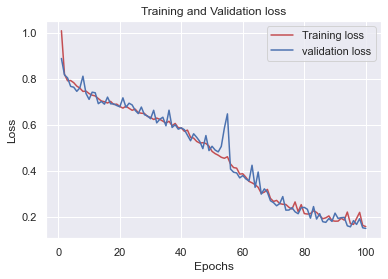

In [455]:
epochs = range(1,101)
plt.plot(epochs, loss_train, 'r', label='Training loss')
plt.plot(epochs, loss_val, 'b', label='validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

Plotting the graph of training accuracy vs. validation accuracy over the number of epochs

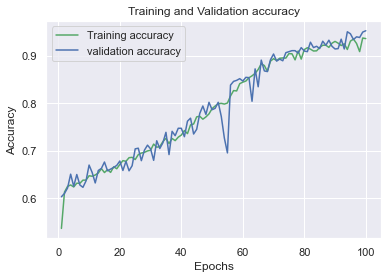

In [456]:
acc_train = history.history['accuracy']
acc_val = history.history['val_accuracy']
plt.plot(epochs, acc_train, 'g', label='Training accuracy')
plt.plot(epochs, acc_val, 'b', label='validation accuracy')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [457]:
predict_x=nn_model.predict(X_nn_test)
y_pred_class=np.argmax(predict_x,axis=1)
y_test_class = np.argmax(y_nn_test, axis=1)
confusion_matrix(y_test_class, y_pred_class)

array([[180,   3,   0,   0,   0,   0,   0,   2],
       [  0, 127,   0,   0,   1,   0,   0,   0],
       [  0,   0, 311,  27,   0,   0,   1,   0],
       [  0,   0,  33, 425,   0,   0,   1,   0],
       [  0,   0,   0,   0,  98,   5,   0,   0],
       [  0,   0,   0,   0,   0,  30,   0,   0],
       [  0,   0,   0,   6,   0,   0, 301,   3],
       [  0,   0,   0,   0,   0,   0,   1, 201]])

In [458]:
cr = classification_report(y_test_class, y_pred_class, target_names= target_names)
print(cr)

              precision    recall  f1-score   support

    classy_1       1.00      0.97      0.99       185
    classy_2       0.98      0.99      0.98       128
      cool_1       0.90      0.92      0.91       339
      cool_2       0.93      0.93      0.93       459
    exotic_1       0.99      0.95      0.97       103
    exotic_2       0.86      1.00      0.92        30
      wild_1       0.99      0.97      0.98       310
      wild_2       0.98      1.00      0.99       202

    accuracy                           0.95      1756
   macro avg       0.95      0.97      0.96      1756
weighted avg       0.95      0.95      0.95      1756

